# Setup and config

In [1]:
! pip install tqdm numpy pandas torch seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 62.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 100.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 117.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 107.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 139.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 119.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 117.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 115.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
import sys
sys.path.append("mount/cnn_ensemble_seq_generation")

In [3]:
from collections import defaultdict
from pathlib import Path
import random
from tqdm import tqdm
from typing import List, Set

import numpy as np
import pandas as pd
import torch
import seaborn as sns

import src.data as data
import src.models as models
import src.training as training

# Data

In [4]:
df = pd.read_csv("mount/data/esm2_15b_embeddings_and_meta.csv")

# Training

## Config

In [ ]:
class TrainingConfig:
    def __init__(self):
        self.learning_rate = 1e-3
        self.batch_size = 64
        self.epochs = 200
        self.weight_decay = 0.01
        self.gradient_clip = 1.0

In [6]:
config = TrainingConfig()

In [7]:
device = 'cuda'

## Data holders

In [8]:
data_holder = data.ESMDataHolder(df)

In [ ]:
all_loader = data_holder.loader_all_data()

In [10]:
train_loader, val_loader = data_holder.train_val_split()

## CNN Ensemble

In [11]:
model = models.Ensemble().to("cuda")

In [12]:
model = training.train_variant_cnn(model, train_loader, val_loader, config, device, updates=True)

  8%|▊         | 15/200 [01:59<24:38,  7.99s/it, train_loss=0.3362, val_loss=4.9621]Exception ignored in: <bound method Random.seed of <random.Random object at 0x56548d8e9990>>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/random.py", line 163, in seed
    super().seed(a)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
training.r2_score_for_model_and_loader(model, val_loader)

0.8410784006118774

In [ ]:
# Save the trained model
model_path = Path("mount/cnn_ensemble_seq_generation/cnn_ensemble_model.pth")
torch.save(model.state_dict(), model_path)

# Generate sequences

## Training CNN ensemble

## Generate sequences at a specific hamming distance

In [ ]:
def generate_mutant_sequences(wt_sequence: str, n_mutations: int = 4, n_sequences: int = 10) -> List[str]:
    """
    Generate protein sequences with exactly n mutations from a wild-type sequence.
    
    Args:
        wt_sequence (str): Wild-type protein sequence using single letter amino acid codes
        n_mutations (int): Number of mutations per sequence
        n_sequences (int): Number of mutant sequences to generate
    
    Returns:
        List[str]: List of mutated sequences
    
    Raises:
        ValueError: If inputs are invalid
    """
    VALID_AA = set('ACDEFGHIKLMNPQRSTVWY')

    def mutate_sequence(seq: str, positions: List[int]) -> str:
        seq_list = list(seq)
        key = []
        for pos in positions:
            
            # Get all possible mutations at this position
            possible_mutations = VALID_AA - {seq[pos]}

            mutation = random.choice(list(possible_mutations))
            seq_list[pos] = mutation
            key.append(f"{pos}{mutation}")
        return ":".join(key), ''.join(seq_list)
    
    generated_sequences: Set[str] = set()
    
    while len(generated_sequences) < n_sequences:
        mutation_positions = random.sample(range(len(wt_sequence)), n_mutations)
        key, new_sequence = mutate_sequence(wt_sequence, mutation_positions)
        
        if new_sequence not in generated_sequences:
            generated_sequences.add((key, new_sequence))
            
    return list(generated_sequences)

In [13]:
wt_seq = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

In [ ]:
mutants = generate_mutant_sequences(wt_seq, n_mutations=4, n_sequences=1000)

## Filter out existing sequences

In [ ]:
df_seqs = pd.read_csv("../data/seq_and_score.csv")

In [ ]:
existing_seqs = set(df_seqs.sequence)

In [ ]:
new_seqs = [(k, s) for k, s in mutants if s not in existing_seqs]

In [ ]:
len(new_seqs)

In [ ]:
with open("outputs/new_seqs.fasta", "w") as fh:
    for key, seq in new_seqs:
        fh.write(f">{key}\n")
        fh.write(f"{seq}\n")

## Generate embeddings for new seqs

In [ ]:
! python src/embeddings.py --fasta outputs/new_seqs.fasta --output_dir outputs/new_seq_embeddings --truncation_seq_length 238

## Predict activity for the new seqs

In [27]:
# Process all sequence embeddings and generate predictions

# Loop over all the embeddings in the directory
embedding_dir = Path("mount/cnn_ensemble_seq_generation/outputs/all_seqs_embeddings/")
embedding_files = list(embedding_dir.glob("*.pt"))

labels = []
embeddings = []
sequences = []

print(f"Processing {len(embedding_files)} embedding files...")

# Extract labels and embeddings from all files
for emb_file in tqdm(embedding_files):
    data = torch.load(emb_file)
    label = data["label"]
    embedding = data["mean_representations"][47]  # Use layer 47 like in the previous code
    
    # Convert label to actual sequence (WT + mutations)
    seq = list(wt_seq)
    for mutation in label.split(":"):
        pos = int(mutation[:-1])
        new_aa = mutation[-1]
        seq[pos] = new_aa
    sequence = "".join(seq)
    
    labels.append(label)
    embeddings.append(embedding)
    sequences.append(sequence)

# Convert embeddings to tensor
embeddings_tensor = torch.tensor(np.array(embeddings)).to(torch.float).to("cuda")

# Generate predictions using the trained model
with torch.no_grad():
    predictions = model(embeddings_tensor).cpu().detach().numpy().flatten()

# Create results dataframe
results_df = pd.DataFrame({
    "label": labels,
    "sequence": sequences,
    "predicted_score": predictions
})

# Sort by predicted score (highest first)
results_df = results_df.sort_values("predicted_score", ascending=False)

# Save results
results_df.to_csv("mount/cnn_ensemble_seq_generation/outputs/all_sequences_predictions.csv", index=False)
torch.save(results_df, "mount/cnn_ensemble_seq_generation/outputs/all_sequences_predictions.pt")

print(f"Processed {len(results_df)} sequences")
print(f"Score range: {results_df['predicted_score'].min():.3f} to {results_df['predicted_score'].max():.3f}")
print(f"Results saved to mount/cnn_ensemble_seq_generation/outputs/all_sequences_predictions.csv")

Processing 100 embedding files...


100%|██████████| 100/100 [00:00<00:00, 245.28it/s]

Processed 100 sequences
Score range: 1.470 to 4.069
Results saved to mount/cnn_ensemble_seq_generation/outputs/all_sequences_predictions.csv


In [ ]:
predictions = predicted_activities.cpu().detach().numpy()
sorted_indices = np.argsort(predictions)
top_variants = np.array(variants)[sorted_indices]
top_variants = top_variants[-100:]

In [ ]:
seqs = []
for variant in top_variants:
    seq = list(wt_seq)
    for var in variant.split(":"):
        pos = int(var[:-1])
        seq[pos] = var[-1]
    seqs.append((variant, "".join(seq)))

In [ ]:
with open("outputs/new_top_score_seqs.fasta", "w") as fh:
    for header, seq in seqs:
        fh.write(f">{header}\n")
        fh.write(f"{seq}\n")

In [ ]:
! cat outputs/new_top_score_seqs.fasta

## Run sequences through QC

## Select highest activity sequences write to file

In [ ]:
! apt-get update -y && apt-get install -y ca-certificates

In [ ]:
! pip install fair-esm fairscale

In [ ]:
! python mount/notebooks/src/embeddings.py --fasta mount/cnn_ensemble_seq_generation/outputs/all_sequences.fasta --output_dir mount/cnn_ensemble_seq_generation/outputs/all_seqs_embeddings

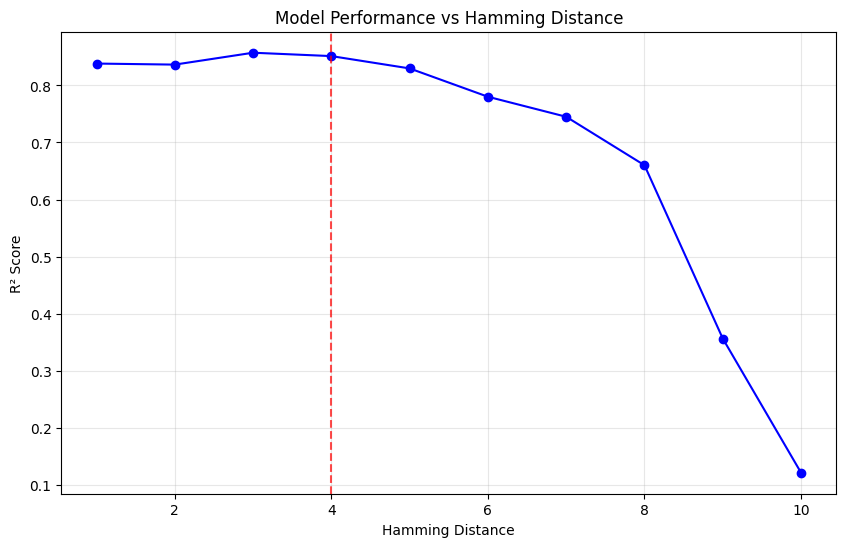

In [15]:
def evaluate_model_at_hamming_distance(model, data_holder, distance):
    """Evaluate model R² score at a specific Hamming distance."""
    filtered_data = data_holder.for_cut_offs(min_distance=distance, max_distance=distance)
    loader = filtered_data.loader_all_data()
    return training.r2_score_for_model_and_loader(model, loader)

hamming_distances = range(df['num_mutations'].min(), 11)
r2_scores = []

for dist in hamming_distances:
    r2 = evaluate_model_at_hamming_distance(model, data_holder, dist)
    r2_scores.append(r2)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(hamming_distances, r2_scores, 'bo-')
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Hamming Distance')
plt.ylabel('R² Score')
plt.title('Model Performance vs Hamming Distance')
plt.grid(True, alpha=0.3)
plt.savefig('model_performance_vs_hamming_distance.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# Plot mean brightness by hamming distance with error bars
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and standard error by hamming distance
hamming_stats = df.groupby('num_mutations')['score'].agg(['mean', 'sem', 'count']).reset_index()

plt.figure(figsize=(10, 6))
plt.errorbar(hamming_stats['num_mutations'], hamming_stats['mean'], 
             yerr=hamming_stats['sem'], fmt='bo-', capsize=5, capthick=1)
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Hamming Distance')
plt.ylabel('Mean Brightness (Score)')
plt.title('Mean Brightness vs Hamming Distance')
plt.grid(True, alpha=0.3)
plt.savefig('mean_brightness_vs_hamming_distance.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

# Print summary statistics
print("Summary statistics by Hamming Distance:")
print(f"{'Distance':<10} {'Mean':<10} {'SEM':<10} {'Count':<10}")
print("-" * 42)
for _, row in hamming_stats.iterrows():
    print(f"{row['num_mutations']:<10} {row['mean']:<10.3f} {row['sem']:<10.3f} {row['count']:<10}")

SyntaxError: unmatched ')' (4250289273.py, line 24)

Top 5 predicted scores: [4.069393  3.9643793 3.868021  3.629906  3.6293871]
Bottom 5 predicted scores: [1.9792874 1.8068151 1.7962792 1.7058613 1.4701645]
Top 5 range: 3.629 - 4.069
Bottom 5 range: 1.470 - 1.979


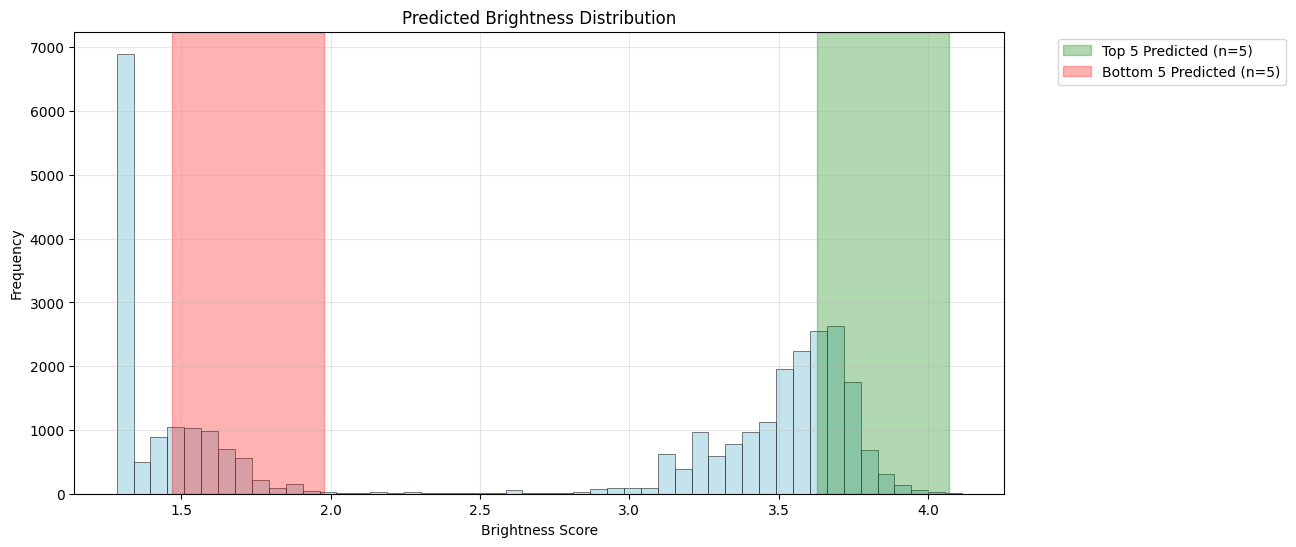


Summary:
Full dataset sequences: 31565
Sequences in top 5 predicted region: 7046 (22.3%)
Sequences in bottom 5 predicted region: 4573 (14.5%)


In [ ]:
# Create brightness histogram with shaded regions for top/bottom 5 predicted sequences
import matplotlib.pyplot as plt
import numpy as np

# Get top 5 and bottom 5 predicted sequences
top_5_scores = results_df.head(5)['predicted_score'].values
bottom_5_scores = results_df.tail(5)['predicted_score'].values

# Create histogram of all brightness values from main dataset
plt.figure(figsize=(12, 6))
plt.hist(df['score'], bins=50, alpha=0.7, color='lightblue', edgecolor='black', linewidth=0.5)

# Add shaded regions for top 5 and bottom 5 predicted sequences
plt.axvspan(top_5_scores.min(), top_5_scores.max(), alpha=0.3, color='green', label=f'Top 5 Predicted')
plt.axvspan(bottom_5_scores.min(), bottom_5_scores.max(), alpha=0.3, color='red', label=f'Bottom 5 Predicted')

# Styling and labels
plt.xlabel('Brightness Score')
plt.ylabel('Frequency')
plt.title('Predicted Brightness Distribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('brightness_histogram_with_prediction_regions.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

# Summary statistics
full_dataset_count = len(df)
top_region_count = len(df[(df['score'] >= top_5_scores.min()) & (df['score'] <= top_5_scores.max())])
bottom_region_count = len(df[(df['score'] >= bottom_5_scores.min()) & (df['score'] <= bottom_5_scores.max())])

print(f"\nSummary:")
print(f"Full dataset sequences: {full_dataset_count}")
print(f"Sequences in top 5 predicted region: {top_region_count} ({top_region_count/full_dataset_count*100:.1f}%)")
print(f"Sequences in bottom 5 predicted region: {bottom_region_count} ({bottom_region_count/full_dataset_count*100:.1f}%)")